## TODO

Flash energy calculation

In [1]:
import glob
import numpy as np
import datetime
import xarray as xr

from pyxlma.lmalib.io import read as lma_read
from pyxlma.plot.xlma import XlmaPlot

from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats
from pyxlma.lmalib.grid import  create_regular_grid, groupby_regular_bins, events_to_grid

%matplotlib inline

In [2]:
files_grabbed = list(sorted(glob.glob('../test/vanna/kinda/L*')))
lma_data, starttime = lma_read.dataset(files_grabbed)
# print(files_grabbed)

# lma_data, starttime = lma_read.dataset(['/data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.dat.gz'])

# lf = read.lmafile(files_grabbed[-1])
# Station info comes from the last file read.
# stations = lma_file.stations

# Will need to add logic to check for existing data and do something else if it is
# if len(lma_data) > 0:
#     lma_data.sort_values('Datetime', inplace=True)

dttuple = [starttime, starttime+datetime.timedelta(minutes=10)]
# dttuple = lma_data.Datetime.min(), lma_data.Datetime.max()
tstring = 'LMA {}-{}'.format(dttuple[0].strftime('%H%M'),
                                      dttuple[1].strftime('%H%M UTC %d %B %Y '))
print(tstring, dttuple)

LMA 2300-2310 UTC 02 April 2020  [datetime.datetime(2020, 4, 2, 23, 0), datetime.datetime(2020, 4, 2, 23, 10)]


In [3]:
# Change the dictionaries below to a consistent set of coordinates
# and adjust grid_spatial_coords in the call to events_to_grid to 
# change what is gridded (various time series of 1D, 2D, 3D grids)

event_coord_names = {
    'event_latitude':'grid_latitude_edge',
    'event_longitude':'grid_longitude_edge',
#     'event_altitude':'grid_altitude_edge',
    'event_time':'grid_time_edge',
}

flash_ctr_names = {
    'flash_init_latitude':'grid_latitude_edge',
    'flash_init_longitude':'grid_longitude_edge',
#     'flash_init_altitude':'grid_altitude_edge',
    'flash_time_start':'grid_time_edge',
}
flash_init_names = {
    'flash_center_latitude':'grid_latitude_edge',
    'flash_center_longitude':'grid_longitude_edge',
#     'flash_center_altitude':'grid_altitude_edge',
    'flash_time_start':'grid_time_edge',
}

# Oklahoma
lat_range = (34.5, 36.5, 0.02)
lon_range = (-100, -98.01, 0.02)
alt_range = (0, 18e3, 1.0e3)

# Houston
# 29.7600000 -95.3700000
# lat_range = (27.75, 31.75, 0.025)
# lon_range = (-97.37, -93.37, 0.025)
# alt_range = (0, 18e3, 1.0e3)


grid_dt = np.asarray(60, dtype='m8[s]')
grid_t0 = np.asarray(dttuple[0]).astype('datetime64[ns]')
grid_t1 = np.asarray(dttuple[1]).astype('datetime64[ns]')
time_range = (grid_t0, grid_t1+grid_dt, grid_dt)

grid_edge_ranges ={
    'grid_latitude_edge':lat_range,
    'grid_longitude_edge':lon_range,
#     'grid_altitude_edge':alt_range,
    'grid_time_edge':time_range,
}
grid_center_names ={
    'grid_latitude_edge':'grid_latitude',
    'grid_longitude_edge':'grid_longitude',
#     'grid_altitude_edge':'grid_altitude',
    'grid_time_edge':'grid_time',
}

In [4]:
ds = cluster_flashes(lma_data)
ds = flash_stats(ds)

In [5]:
def rho_br(z, separation, e_0=8.85418782e-12):
    '''
    Compute critical electric field from initiation altitudes.
    From the electric field, compute critical charge density.
    Approximates the electric field at breakdown using the runaway
    breakeven threshold as a function of altitude.

    args: z, separation = initiation and plate separation altitudes in km 
    returns: rho_critical in kV/m
    '''
    z = z*1e-3
    rho_a = 1.208 * np.exp(-(z/8.4))
    efield=(167.*rho_a)*1e3
    sig_crit=2*efield*self.e_0
    rho_crit=sig_crit/separation
    return(rho_crit)

def capacitor_energy(z, d, area, e_0=8.85418782e-12, separation_percentiles=(27,73)):
    separation = np.abs(np.percentile(alt,separation_percentiles[1]) -
                        np.percentile(alt,separation_percentiles[0]))
    rho = rho_br(z, d, e_0)
    w = (rho**2. * d**3. * area)/(2. * e_0) 
    return w


In [6]:
ds

<xarray.Dataset>
Dimensions:                              (number_of_events: 35436, number_of_flashes: 2171, number_of_stations: 18)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 0 1 ... 2170
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude              float64 35.28
    network_center_longitude             float64 -97.92
    network_center_altitude              float64 417.9
    station_latitude                     (number_of_stations) float32 35.00434 ... 34.711586
    station_longitude                    (number_of_stations) float32 -97.907295 ... -99.08027
    station_altitude                     (number_of_stations) float32 346.0 ... 415.89996
    station_event_fraction               (number_of_stations) float32 1762.7 ... 884.5
    station_power_ratio                  (number_of_stations) float32 1.9909999 ... 0.842
    event_latitude                       (number_of_events) float32 35.37887 ... 35.386784
    event_longitude                      (number_of_events) float32 -99.74041 ... -99.712746
    event_altitude                       (number_of_events) float32 11685.61 ... 2567.21
    event_time                           (number_of_events) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.305506673
    event_power                          (number_of_events) float32 12.9 ... 3.4
    event_mask                           (number_of_events) uint32 1015 ... 245
    event_stations                       (number_of_events) uint8 9 6 6 ... 8 6
    event_chi2                           (number_of_events) float32 0.05 ... 0.29
    event_contributing_stations          (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                             (number_of_events) uint64 0 1 ... 35435
    station_code                         (number_of_stations) object b'C' ... b'Z'
    flash_distance_separation_threshold  float64 3e+03
    flash_time_separation_threshold      float64 0.15
    flash_duration_threshold             float64 nan
    flash_time_merge_threshold           float64 nan
    flash_time_start                     (number_of_flashes) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.181733991
    flash_time_end                       (number_of_flashes) datetime64[ns] 2020-04-02T23:00:00.749083039 ... 2020-04-02T23:09:55.204144025
    flash_duration                       (number_of_flashes) timedelta64[ns] -1 days +23:59:59.999996 ... -1 days +23:59:59.977589
    flash_init_latitude                  (number_of_flashes) float32 35.37887 ... 35.411808
    flash_init_longitude                 (number_of_flashes) float32 -99.74041 ... -99.762566
    flash_init_altitude                  (number_of_flashes) float32 11685.61 ... 7825.12
    flash_area                           (number_of_flashes) float32 0.0 ... 0.0
    flash_volume                         (number_of_flashes) float32 0.0 ... 0.0
    flash_center_latitude                (number_of_flashes) float32 35.376465 ... 35.40959
    flash_center_longitude               (number_of_flashes) float32 -99.73503 ... -99.75267
    flash_center_altitude                (number_of_flashes) float32 11450.305 ... 8560.734
    flash_event_count                    (number_of_flashes) uint32 2 392 ... 2
    event_parent_flash_id                (number_of_events) uint64 0 0 ... 2166
    flash_id                             (number_of_flashes) uint64 0 1 ... 2170
Attributes:
    event_algorithm_version:   10.14.5R
    title:                    Lightning Mapping Array Dataset, L1b events and...
    event_algorithm_name:      /data1/rtlma/bin/lma_analysis_v10.14.5R/lma_an...
    references:               
    production_date:          2020-07-24 21:07:50 +00:00
    history:                  LMA source file created  Thu Apr  2 18:01:21 20...
    institution:              unknown
    production_site:          Default
    source:                   VHF

In [7]:
ds0 = ds.copy()

In [8]:
ds0

<xarray.Dataset>
Dimensions:                              (number_of_events: 35436, number_of_flashes: 2171, number_of_stations: 18)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 0 1 ... 2170
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude              float64 35.28
    network_center_longitude             float64 -97.92
    network_center_altitude              float64 417.9
    station_latitude                     (number_of_stations) float32 35.00434 ... 34.711586
    station_longitude                    (number_of_stations) float32 -97.907295 ... -99.08027
    station_altitude                     (number_of_stations) float32 346.0 ... 415.89996
    station_event_fraction               (number_of_stations) float32 1762.7 ... 884.5
    station_power_ratio                  (number_of_stations) float32 1.9909999 ... 0.842
    event_latitude                       (number_of_events) float32 35.37887 ... 35.386784
    event_longitude                      (number_of_events) float32 -99.74041 ... -99.712746
    event_altitude                       (number_of_events) float32 11685.61 ... 2567.21
    event_time                           (number_of_events) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.305506673
    event_power                          (number_of_events) float32 12.9 ... 3.4
    event_mask                           (number_of_events) uint32 1015 ... 245
    event_stations                       (number_of_events) uint8 9 6 6 ... 8 6
    event_chi2                           (number_of_events) float32 0.05 ... 0.29
    event_contributing_stations          (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                             (number_of_events) uint64 0 1 ... 35435
    station_code                         (number_of_stations) object b'C' ... b'Z'
    flash_distance_separation_threshold  float64 3e+03
    flash_time_separation_threshold      float64 0.15
    flash_duration_threshold             float64 nan
    flash_time_merge_threshold           float64 nan
    flash_time_start                     (number_of_flashes) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.181733991
    flash_time_end                       (number_of_flashes) datetime64[ns] 2020-04-02T23:00:00.749083039 ... 2020-04-02T23:09:55.204144025
    flash_duration                       (number_of_flashes) timedelta64[ns] -1 days +23:59:59.999996 ... -1 days +23:59:59.977589
    flash_init_latitude                  (number_of_flashes) float32 35.37887 ... 35.411808
    flash_init_longitude                 (number_of_flashes) float32 -99.74041 ... -99.762566
    flash_init_altitude                  (number_of_flashes) float32 11685.61 ... 7825.12
    flash_area                           (number_of_flashes) float32 0.0 ... 0.0
    flash_volume                         (number_of_flashes) float32 0.0 ... 0.0
    flash_center_latitude                (number_of_flashes) float32 35.376465 ... 35.40959
    flash_center_longitude               (number_of_flashes) float32 -99.73503 ... -99.75267
    flash_center_altitude                (number_of_flashes) float32 11450.305 ... 8560.734
    flash_event_count                    (number_of_flashes) uint32 2 392 ... 2
    event_parent_flash_id                (number_of_events) uint64 0 0 ... 2166
    flash_id                             (number_of_flashes) uint64 0 1 ... 2170
Attributes:
    event_algorithm_version:   10.14.5R
    title:                    Lightning Mapping Array Dataset, L1b events and...
    event_algorithm_name:      /data1/rtlma/bin/lma_analysis_v10.14.5R/lma_an...
    references:               
    production_date:          2020-07-24 21:07:50 +00:00
    history:                  LMA source file created  Thu Apr  2 18:01:21 20...
    institution:              unknown
    production_site:          Default
    source:                   VHF

In [9]:

grid_ds = create_regular_grid(grid_edge_ranges, grid_center_names)

ds, ev_gb = groupby_regular_bins(grid_ds, ds0, event_coord_names, pixel_id_var='event_pixel_id', append_indices=True)
ds, flctr_gb = groupby_regular_bins(grid_ds, ds, flash_ctr_names, pixel_id_var='flash_ctr_pixel_id', append_indices=True)
ds, flini_gb = groupby_regular_bins(grid_ds, ds, flash_init_names, pixel_id_var='flash_init_pixel_id', append_indices=True)

event_latitude
event_longitude
event_time
flash_init_latitude
flash_init_longitude
flash_time_start
flash_center_latitude
flash_center_longitude
flash_time_start


In [10]:
ds

<xarray.Dataset>
Dimensions:                                            (number_of_events: 35358, number_of_flashes: 2093, number_of_stations: 18)
Coordinates:
  * number_of_flashes                                  (number_of_flashes) uint64 0 ... 2170
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude                            float64 35.28
    network_center_longitude                           float64 -97.92
    network_center_altitude                            float64 417.9
    station_latitude                                   (number_of_stations) float32 35.00434 ... 34.711586
    station_longitude                                  (number_of_stations) float32 -97.907295 ... -99.08027
    station_altitude                                   (number_of_stations) float32 346.0 ... 415.89996
    station_event_fraction                             (number_of_stations) float32 1762.7 ... 884.5
    station_power_ratio                                (number_of_stations) float32 1.9909999 ... 0.842
    event_latitude                                     (number_of_events) float32 35.37887 ... 35.386784
    event_longitude                                    (number_of_events) float32 -99.74041 ... -99.712746
    event_altitude                                     (number_of_events) float32 11685.61 ... 2567.21
    event_time                                         (number_of_events) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.305506673
    event_power                                        (number_of_events) float32 12.9 ... 3.4
    event_mask                                         (number_of_events) uint32 1015 ... 245
    event_stations                                     (number_of_events) uint8 9 ... 6
    event_chi2                                         (number_of_events) float32 0.05 ... 0.29
    event_contributing_stations                        (number_of_events, number_of_stations) uint8 1 ... 0
    event_id                                           (number_of_events) uint64 0 ... 35435
    station_code                                       (number_of_stations) object b'C' ... b'Z'
    flash_distance_separation_threshold                float64 3e+03
    flash_time_separation_threshold                    float64 0.15
    flash_duration_threshold                           float64 nan
    flash_time_merge_threshold                         float64 nan
    flash_time_start                                   (number_of_flashes) datetime64[ns] 2020-04-02T23:00:00.749079563 ... 2020-04-02T23:09:55.181733991
    flash_time_end                                     (number_of_flashes) datetime64[ns] 2020-04-02T23:00:00.749083039 ... 2020-04-02T23:09:55.204144025
    flash_duration                                     (number_of_flashes) timedelta64[ns] -1 days +23:59:59.999996 ... -1 days +23:59:59.977589
    flash_init_latitude                                (number_of_flashes) float32 35.37887 ... 35.411808
    flash_init_longitude                               (number_of_flashes) float32 -99.74041 ... -99.762566
    flash_init_altitude                                (number_of_flashes) float32 11685.61 ... 7825.12
    flash_area                                         (number_of_flashes) float32 0.0 ... 0.0
    flash_volume                                       (number_of_flashes) float32 0.0 ... 0.0
    flash_center_latitude                              (number_of_flashes) float32 35.376465 ... 35.40959
    flash_center_longitude                             (number_of_flashes) float32 -99.73503 ... -99.75267
    flash_center_altitude                              (number_of_flashes) float32 11450.305 ... 8560.734
    flash_event_count                                  (number_of_flashes) uint32 2 ... 2
    event_parent_flash_id                              (number_of_events) uint64 0 ... 2166
    flash_id                                           (n

In [11]:
grid_ds

<xarray.Dataset>
Dimensions:              (grid_latitude: 99, grid_latitude_edge: 100, grid_longitude: 99, grid_longitude_edge: 100, grid_time: 10, grid_time_edge: 11)
Coordinates:
  * grid_latitude_edge   (grid_latitude_edge) float64 34.5 34.52 ... 36.46 36.48
  * grid_latitude        (grid_latitude) float64 34.51 34.53 ... 36.45 36.47
  * grid_longitude_edge  (grid_longitude_edge) float64 -100.0 -99.98 ... -98.02
  * grid_longitude       (grid_longitude) float64 -99.99 -99.97 ... -98.03
  * grid_time_edge       (grid_time_edge) datetime64[ns] 2020-04-02T23:00:00 ... 2020-04-02T23:10:00
  * grid_time            (grid_time) datetime64[ns] 2020-04-02T23:00:30 ... 2020-04-02T23:09:30
Data variables:
    *empty*

In [12]:
grid_ds = events_to_grid(ev_gb, grid_ds, min_points_per_flash=3,
                         grid_spatial_coords=['grid_time', None, 'grid_latitude', 'grid_longitude'],
#                          grid_spatial_coords=['grid_time', 'grid_altitude', None, None],
                        )

In [13]:
grid_ds

<xarray.Dataset>
Dimensions:               (grid_latitude: 99, grid_latitude_edge: 100, grid_longitude: 99, grid_longitude_edge: 100, grid_time: 10, grid_time_edge: 11)
Coordinates:
  * grid_latitude_edge    (grid_latitude_edge) float64 34.5 34.52 ... 36.48
  * grid_latitude         (grid_latitude) float64 34.51 34.53 ... 36.45 36.47
  * grid_longitude_edge   (grid_longitude_edge) float64 -100.0 -99.98 ... -98.02
  * grid_longitude        (grid_longitude) float64 -99.99 -99.97 ... -98.03
  * grid_time_edge        (grid_time_edge) datetime64[ns] 2020-04-02T23:00:00 ... 2020-04-02T23:10:00
  * grid_time             (grid_time) datetime64[ns] 2020-04-02T23:00:30 ... 2020-04-02T23:09:30
Data variables:
    event_count           (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    event_total_power     (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    flash_extent_density  (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    average_flash_area    (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    stdev_flash_area      (grid_time, grid_latitude, grid_longitude) float64 nan ... nan
    minimum_flash_area    (grid_time, grid_latitude, grid_longitude) float64 nan ... nan

**Time-height grids**

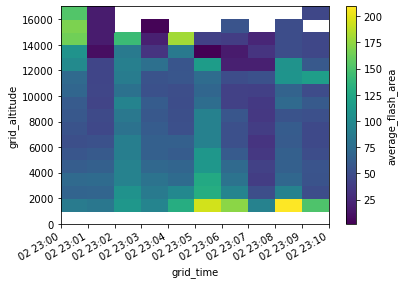

In [16]:
grid_ds.average_flashaa_area.T.plot()

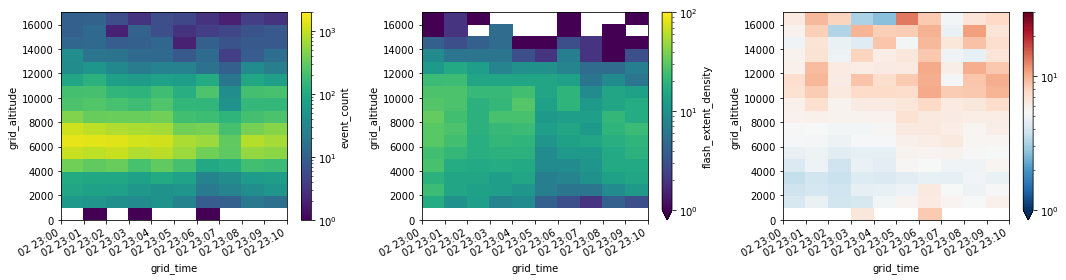

In [94]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(15,4))
grid_ds.event_count.T.plot(norm=LogNorm(vmin=1, vmax=2000), ax=axs[0])
grid_ds.flash_extent_density.T.plot(norm=LogNorm(vmin=1, vmax=100), ax=axs[1])
(grid_ds.event_total_power/grid_ds.event_count).T.plot(norm=LogNorm(vmin=1, vmax=30), ax=axs[2])
fig.tight_layout()

**2D spatial grids; sum over time**

/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


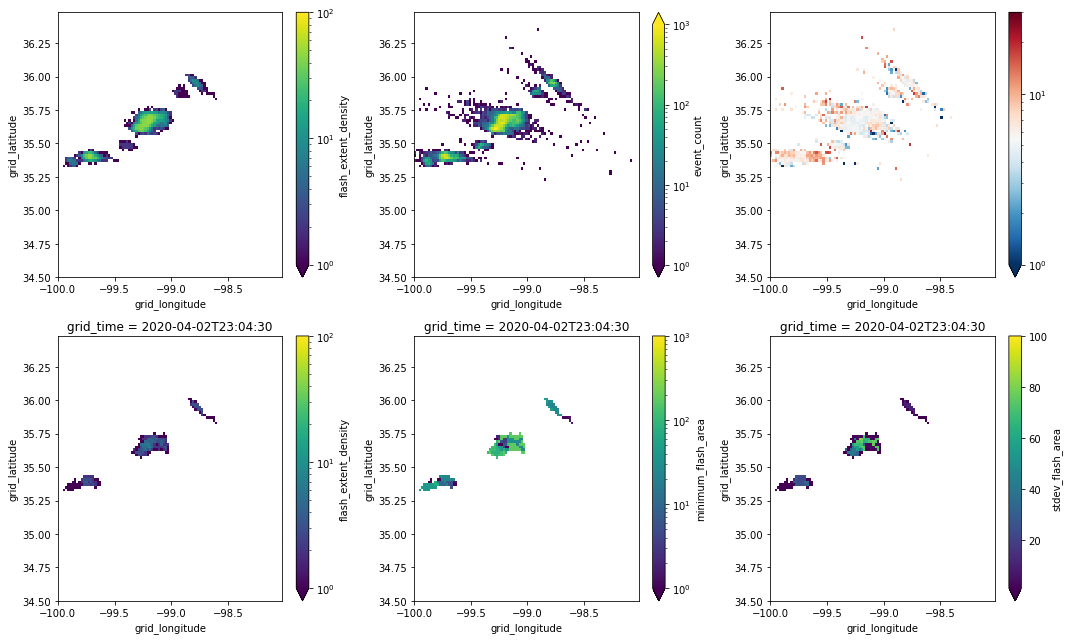

In [14]:
# empty = np.isnan(grid_ds.event_count)
# grid_ds['event_count'] = grid_ds['event_count'].fillna(0)
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3, figsize=(15,9))
axs=axs.flatten()
grid_ds.event_count.sum(axis=(0,)).plot.imshow(norm=LogNorm(vmin=1, vmax=1000), ax=axs[1])
grid_ds.flash_extent_density.sum(axis=(0,)).plot.imshow(norm=LogNorm(vmin=1, vmax=100), ax=axs[0])
(grid_ds.event_total_power.sum(axis=(0,))/grid_ds.event_count.sum(axis=(0,))).plot.imshow(norm=LogNorm(vmin=1, vmax=30), ax=axs[2])
grid_ds.flash_extent_density[4,:,:].plot.imshow(norm=LogNorm(vmin=1, vmax=100), ax=axs[3])
grid_ds.minimum_flash_area[4,:,:].plot.imshow(norm=LogNorm(vmin=1, vmax=1000), ax=axs[4])
grid_ds.stdev_flash_area[4,:,:].plot.imshow(vmin=1, vmax=100, ax=axs[5])

fig.tight_layout()

In [20]:
both_ds = xr.combine_by_coords((grid_ds, ds))

In [24]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in both_ds.data_vars}
both_ds.to_netcdf('/data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.nc', encoding=encoding)

In [26]:
ls -lh /data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.nc

-rw-r--r--  1 ebruning  staff   4.6M Jul 24 15:23 /data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.nc


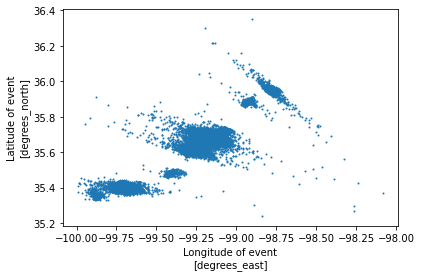

In [89]:
ds.plot.scatter('event_longitude', 'event_latitude', s=1)#, c='event_altitude')

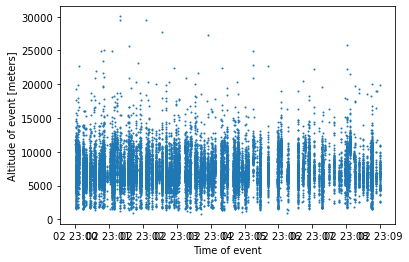

In [88]:
ds.plot.scatter('event_time', 'event_altitude', s=1)#, c='event_altitude')